In [1]:
'''link dataset
https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
'''

'link dataset\nhttps://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset\n\n'

In [2]:
from pathlib import Path
import os
import re
import html
import string

import unicodedata
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix


import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
dffake = pd.read_csv(r"/kaggle/input/fake-and-real-news-dataset/Fake.csv")
dffake['news_type'] = 0
dffake

,title,text,subject,date,news_type
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [4]:
dftrue = pd.read_csv(r"/kaggle/input/fake-and-real-news-dataset/True.csv")
dftrue['news_type'] = 1
dftrue

,title,text,subject,date,news_type
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


In [5]:
df =  pd.concat([dffake, dftrue], ignore_index = True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,title,text,subject,date,news_type
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1
...,...,...,...,...,...
44893,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,,politics,"Mar 27, 2017",0
44894,PM May seeks to ease Japan's Brexit fears duri...,LONDON/TOKYO (Reuters) - British Prime Ministe...,worldnews,"August 29, 2017",1
44895,Merkel: Difficult German coalition talks can r...,BERLIN (Reuters) - Chancellor Angela Merkel sa...,worldnews,"November 16, 2017",1
44896,Trump Stole An Idea From North Korean Propaga...,Jesus f*cking Christ our President* is a moron...,News,"July 14, 2017",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   news_type  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [7]:
df.isnull().sum()

title        0
text         0
subject      0
date         0
news_type    0
dtype: int64

In [8]:
df.duplicated().sum()


209

In [9]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()


0

In [10]:
df['news_type'].value_counts()


news_type
0    23478
1    21211
Name: count, dtype: int64

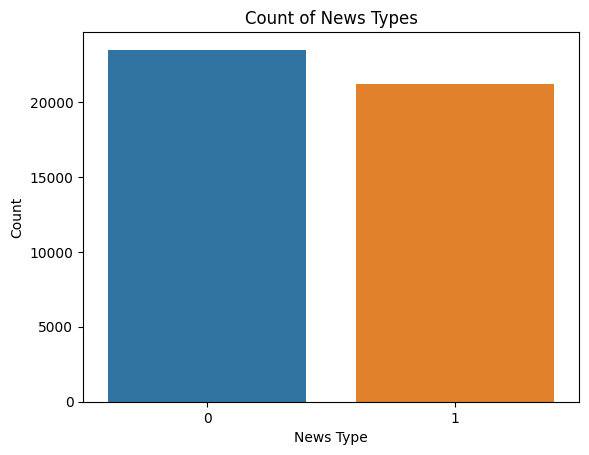

In [11]:
# Create the count plot
sns.countplot(x='news_type', data=df)

# Add labels and a title
plt.xlabel('News Type')
plt.ylabel('Count')
plt.title('Count of News Types')
plt.show()


In [12]:
df['text'][0]

'21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative statements on Judge Jeanine Pirro s show recently. While discussing the halt that was imposed on President Trump s Executive Order on travel. Stein referred to the judgement by the 9th Circuit Court in Washington state as a  Coup d tat against the executive branch and against the constitution.  Stein went on to call the Judges in Seattle  political puppets  and the judiciary  political pawns. Watch the interview below for the complete statements and note the stark contrast to the rhetoric of the leftist media and pundits who neglect to note that no court has ever blocked any Presidential orders in immigration in the past or discuss the legal efficacy of the halt or the actual text of the Executive Order.READ MORE TRUMP NEWS AT: 21st Century Wire Trump FilesSUPPORT OUR WORK BY SUBSCRIBING &

In [13]:
df['clean_text'] = df['text'].str.lower()
df.sample(frac=1).head()

,title,text,subject,date,news_type,clean_text
27353,WATCH: Why NFL Players Taking A Knee Is Total ...,"Outspoken conservative Paul Joseph Watson is, ...",politics,"Sep 25, 2017",0,"outspoken conservative paul joseph watson is, ..."
31797,U.S. Treasury dashes hopes for near-term World...,WASHINGTON (Reuters) - A U.S. Treasury officia...,politicsNews,"October 11, 2017",1,washington (reuters) - a u.s. treasury officia...
8613,Houston port continues salvage efforts to reco...,HOUSTON (Reuters) - Salvage efforts continued ...,politicsNews,"September 4, 2017",1,houston (reuters) - salvage efforts continued ...
12850,"U.S. to send over 3,000 troops to Afghanistan:...",WASHINGTON (Reuters) - U.S. Defense Secretary ...,worldnews,"September 18, 2017",1,washington (reuters) - u.s. defense secretary ...
3702,BREAKING: D.C. Driver Plows Into Capitol Polic...,It happened around 9:30 a.m. at the 100 block ...,Government News,"Mar 29, 2017",0,it happened around 9:30 a.m. at the 100 block ...


In [14]:
def remove_punctuation(text):
    punc = string.punctuation
    return text.translate(str.maketrans('','',punc))


df['clean_text'] = df['clean_text'].apply(lambda x:remove_punctuation(x))
df.head()

,title,text,subject,date,news_type,clean_text
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0,21st century wire says ben stein reputable pro...
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1,washington reuters us president donald trump ...
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1,reuters puerto rico governor ricardo rossello...
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0,on monday donald trump once again embarrassed ...
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1,glasgow scotland reuters most us presidential...


In [15]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join({word for word in text.split() if word not in stop_words})

df['clean_text'] = df['clean_text'].apply(lambda x:remove_stopwords(x))
df.head()

,title,text,subject,date,news_type,clean_text
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0,jeanine show ferris actual provocative rhetori...
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1,anonymity jinping ezra includes november told ...
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1,fuel” version show homeland grant food asked p...
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0,extremely cnnpolitics 22 confirmed israel name...
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1,scotland’s united skills arrives homeland mini...


In [16]:
df

,title,text,subject,date,news_type,clean_text
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0,jeanine show ferris actual provocative rhetori...
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1,anonymity jinping ezra includes november told ...
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1,fuel” version show homeland grant food asked p...
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0,extremely cnnpolitics 22 confirmed israel name...
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1,scotland’s united skills arrives homeland mini...
...,...,...,...,...,...,...
44893,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,,politics,"Mar 27, 2017",0,
44894,PM May seeks to ease Japan's Brexit fears duri...,LONDON/TOKYO (Reuters) - British Prime Ministe...,worldnews,"August 29, 2017",1,hokkaido better united position north toyota m...
44895,Merkel: Difficult German coalition talks can r...,BERLIN (Reuters) - Chancellor Angela Merkel sa...,worldnews,"November 16, 2017",1,believes face angela talks today reach chancel...
44896,Trump Stole An Idea From North Korean Propaga...,Jesus f*cking Christ our President* is a moron...,News,"July 14, 2017",0,hey quality 2017so nephew patrick foot brownis...


In [17]:
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(df['clean_text'])



In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test , y_train,y_test = train_test_split(df['clean_text'],df['news_type'],test_size=0.2,random_state=42)

In [19]:
# Convert texts to sequences
x_train_seq = tok.texts_to_sequences(x_train)
x_test_seq = tok.texts_to_sequences(x_test)

In [20]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [21]:
classes_lb = lb.classes_
classes_lb

array([0, 1])

In [22]:
def get_max_len(texts):
  return max([len(word_tokenize(text)) for text in texts])
maxlen = get_max_len(df['clean_text'])
#maxlen = 100


In [23]:
maxlen

2396

In [24]:
maxlen=2400

In [25]:
# Pad sequences to the same length
x_train = pad_sequences(x_train_seq, maxlen=maxlen, padding='post', truncating='post')  # Adjust `maxlen` as needed
x_test = pad_sequences(x_test_seq, maxlen=maxlen, padding='post', truncating='post')


In [26]:
print("First padded training sequence:", x_train[0])
print("First padded testing sequence:", x_test[0])


First padded training sequence: [184   1 115 ...   0   0   0]
First padded testing sequence: [6152 6195  140 ...    0    0    0]


In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization

embedding_size = 100

# Model: Enhanced LSTM with multiple layers
model = Sequential()
model.add(Embedding(vocab_sz + 1, embedding_size, mask_zero=True, input_length=maxlen))

# Add the first LSTM layer
model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))  # Return sequences to pass to the next LSTM layer
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Add a second LSTM layer
model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

# Add a third LSTM layer
model.add(LSTM(100,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

# Add a fully connected layer
model.add(Dense(64, activation='relu'))  # Intermediate dense layer for more learning capacity
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout for dense layer

# Output layer
model.add(Dense(2, activation='softmax'))  # For classification

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',  # Use sparse if labels are integers
    optimizer='adam',
    metrics=['accuracy']
)

# Model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint = EarlyStopping(monitor='val_accuracy',patience = 5 ,mode='max')
callbacks_lst = [checkpoint]


In [29]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

callbacks_lst = [checkpoint]
# Training
batch_size = 256
epochs = 10
print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=callbacks_lst)



Train...
Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1601s 14s/step - accuracy: 0.8968 - loss: 0.2113 - val_accuracy: 0.9934 - val_loss: 0.1242
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1586s 14s/step - accuracy: 0.9939 - loss: 0.0203 - val_accuracy: 0.9929 - val_loss: 0.0310
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1582s 14s/step - accuracy: 0.9969 - loss: 0.0120 - val_accuracy: 0.9926 - val_loss: 0.0313
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1582s 14s/step - accuracy: 0.9965 - loss: 0.0116 - val_accuracy: 0.9944 - val_loss: 0.0240
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1582s 14s/step - accuracy: 0.9985 - loss: 0.0060 - val_accuracy: 0.9937 - val_loss: 0.0246
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1579s 14s/step - accuracy: 0.9985 - loss: 0.0059 - val_accuracy: 0.9890 - val_loss: 0.0415
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1588s 14s/step - accuracy: 0.9977 - loss: 0.0071 - val_accuracy: 0.9940 - val_loss: 0.0226
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1596s 14s/step - accuracy: 0.9983 

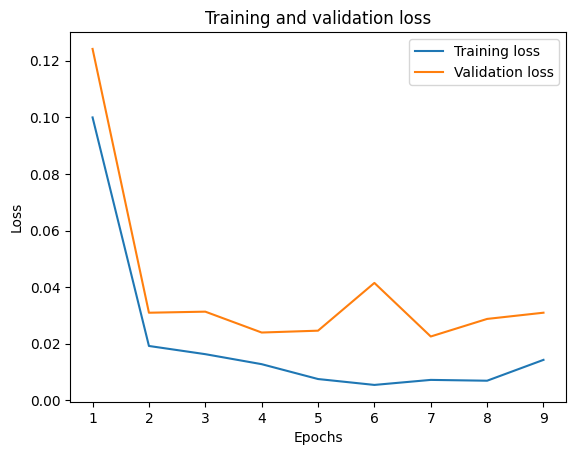

In [30]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

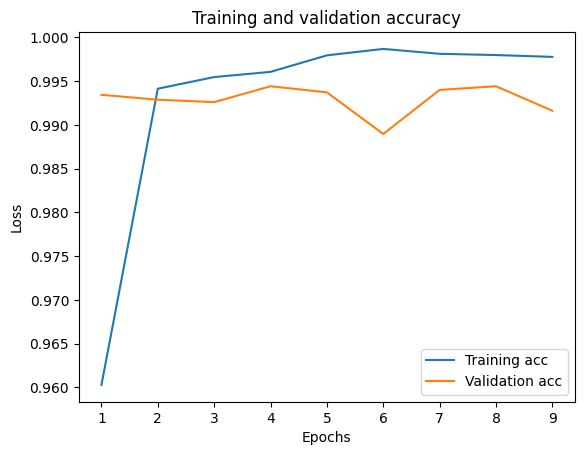

In [31]:

plt.clf()   # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [32]:
# Evaluate the model
results = model.evaluate(x_test, y_test, verbose=1)

# Print the results
print(f"Loss: {results[0]}")
for i, metric_name in enumerate(model.metrics_names[1:], start=1):
    print(f"{metric_name}: {results[i]}")


280/280 ━━━━━━━━━━━━━━━━━━━━ 738s 3s/step - accuracy: 0.9912 - loss: 0.0309
Loss: 0.03152899816632271
compile_metrics: 0.9914969801902771


In [33]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert softmax output to class labels

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

280/280 ━━━━━━━━━━━━━━━━━━━━ 732s 3s/step
Confusion Matrix:
[[4621   31]
 [  45 4241]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4652
           1       0.99      0.99      0.99      4286

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938

